# <span style="background: linear-gradient(135deg,#fce38a,#f38181); -webkit-background-clip: text; color: transparent;font-weight: bold; font-style: italic; font-size: 32pt;">Ordinary Differential Equations Tests for Genetic Programming</span>

## <span style="background: linear-gradient(135deg,#f54ea2,#ff7676); -webkit-background-clip: text; color: transparent;font-weight: bold; font-style: italic; font-size: 24pt;">Harmonic Oscillator  Equation</span>

Given the deterministic conditions:

$$
\frac{\partial^2 u}{\partial x^2} + u = 0\\
u(0) = 0, u(1) = 1
$$

### Data Generation

Get the `X_input` points by sampling randomly on the computational domain. The computational domain is defined by the interval $[0, 1]$ for the variable $x$. The `y_input` is defined as the value of source term $f(x)$ at the corresponding `X_input` point(i.e. equal to 0) and the boundary condition $u(0) = 0$ or $u(1) = 0$. 

Note that in this process, we do not need to know the exact solution of the equation. The `Ground Truth` is used to evaluate the performance of the model.

In [1]:
import numpy as np
import sympy as sp


def calculate_source(solution):
    ''' Calculate the source term of the PDE '''
    # solution: sympy expr of the solution
    real_params = dict()
    for symbol in sp.preorder_traversal(solution):
        if isinstance(symbol, sp.Symbol):
            exec('%s = sp.Symbol("%s")' % (symbol.name, symbol.name))
            if symbol.name not in real_params:
                real_params[symbol.name] = None
    real_params = sorted(list(real_params.keys()))
    print(f'real_params:{real_params}')
    source = 0
    for i in real_params:
        source += sp.diff(solution, i, 2)
    source = source + solution
    print(f'source:{source}')
    solution_func = sp.lambdify(real_params, solution, modules='numpy')
    if source == 0:
        source_func = lambda *args: np.zeros_like(args[0])
    else:
        source_func = sp.lambdify(real_params, source, modules='numpy')
    return solution_func, source_func, real_params

# Validating the solution and the source term
GROUND_TRUTH = sp.sympify('sin(x)/sin(1)')
solution_func, source_func, real_params = calculate_source(GROUND_TRUTH)


real_params:['x']
source:0


In [2]:
np.random.seed(100)
LEFT_BC, RIGHT_BC = 0, 1
N_SAMPLES = 20 # collect n_samples points in the domain
N_BOUNDARY = 20 # collect n_boundary points on the boundary

n_vars = len(real_params)
X = np.random.uniform(LEFT_BC, RIGHT_BC, (N_SAMPLES, n_vars))
X_bc = np.array([[LEFT_BC],[RIGHT_BC]])
assert X_bc.shape == (2, n_vars)
X_combine = np.concatenate([X, X_bc], axis=0)
assert X_combine.shape == (N_SAMPLES+2, n_vars)
y = source_func(*X_combine.T).reshape(-1, 1)
y_bc = solution_func(*X_bc.T).reshape(-1, 1)

X_input = [X, X_bc]
y_input = [y, y_bc] # bc points are computed twice in y and y_bc

test_X = np.random.uniform(LEFT_BC, RIGHT_BC, (N_SAMPLES, n_vars))
test_y = solution_func(*test_X.T)

### Reinforcement Learning 

We use single RL method to solve the ODE with closed form solution. Here we define the equation in the `pde.py` file. and use the configuration file `config_haros` to define the hyperparameters of the model.

In [3]:
import time
from ssde import PDESymbolicSolver

# set the env variable to screen the warning
model = PDESymbolicSolver("./config/config_haros_gp.json")
start_time = time.time()
model.fit(X_input, y_input) # Should solve in ~10 hours
print(model.program_.pretty())
print('Using time(s):', time.time()-start_time)
pred_expr = model.program_.sympy_expr

OMP: Info #155: KMP_AFFINITY: Initial OS proc set respected: 0-79
OMP: Info #216: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #157: KMP_AFFINITY: 80 available OS procs
OMP: Info #158: KMP_AFFINITY: Uniform topology
OMP: Info #287: KMP_AFFINITY: topology layer "LL cache" is equivalent to "socket".
OMP: Info #287: KMP_AFFINITY: topology layer "L3 cache" is equivalent to "socket".
OMP: Info #287: KMP_AFFINITY: topology layer "L2 cache" is equivalent to "core".
OMP: Info #287: KMP_AFFINITY: topology layer "L1 cache" is equivalent to "core".
OMP: Info #192: KMP_AFFINITY: 2 sockets x 20 cores/socket x 2 threads/core (40 total cores)
OMP: Info #218: KMP_AFFINITY: OS proc to physical thread map:
OMP: Info #172: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 thread 0 
OMP: Info #172: KMP_AFFINITY: OS proc 40 maps to socket 0 core 0 thread 1 
OMP: Info #172: KMP_AFFINITY: OS proc 4 maps to socket 0 core 1 thread 0 
OMP: Info #172: KMP_AFFINITY: OS proc 44 maps to socket 0 core 1 thread 1 
OMP:

-- BUILDING PRIOR START -------------
LengthConstraint: Sequences have minimum length 4.
                  Sequences have maximum length 30.
RepeatConstraint: [const] cannot occur more than 1 times.
RelationalConstraint: [exp] cannot be a child of [log].
InverseUnaryConstraint: RelationalConstraint: [log] cannot be a child of [exp].
TrigConstraint: [sin, cos] cannot be a descendant of [sin, cos].
ConstConstraint: [const] cannot be the only unique child of [sin, cos, exp, log, add, sub, mul, div].
NoInputsConstraint: Sequences contain at least one input variable Token.
UniformArityPrior: Activated.
SoftLengthPrior: No description available.
-- BUILDING PRIOR END ---------------

GP Controller using parallel evaluation


OMP: Info #155: KMP_AFFINITY: Initial OS proc set respected: 0-79
OMP: Info #216: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #157: KMP_AFFINITY: 80 available OS procs
OMP: Info #158: KMP_AFFINITY: Uniform topology
OMP: Info #287: KMP_AFFINITY: topology layer "LL cache" is equivalent to "socket".
OMP: Info #287: KMP_AFFINITY: topology layer "L3 cache" is equivalent to "socket".
OMP: Info #287: KMP_AFFINITY: topology layer "L2 cache" is equivalent to "core".
OMP: Info #287: KMP_AFFINITY: topology layer "L1 cache" is equivalent to "core".
OMP: Info #192: KMP_AFFINITY: 2 sockets x 20 cores/socket x 2 threads/core (40 total cores)
OMP: Info #218: KMP_AFFINITY: OS proc to physical thread map:
OMP: Info #172: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 thread 0 
OMP: Info #172: KMP_AFFINITY: OS proc 40 maps to socket 0 core 0 thread 1 
OMP: Info #172: KMP_AFFINITY: OS proc 4 maps to socket 0 core 1 thread 0 
OMP: Info #172: KMP_AFFINITY: OS proc 44 maps to socket 0 core 1 thread 1 
OMP:

	>>> Using 80 processes
-- RUNNING ITERATIONS START -------------


OMP: Info #254: KMP_AFFINITY: pid 86306 tid 86327 thread 1 bound to OS proc set 4
OMP: Info #254: KMP_AFFINITY: pid 86306 tid 86411 thread 2 bound to OS proc set 8
OMP: Info #254: KMP_AFFINITY: pid 86306 tid 86412 thread 3 bound to OS proc set 6
OMP: Info #254: KMP_AFFINITY: pid 86306 tid 86413 thread 4 bound to OS proc set 2
OMP: Info #254: KMP_AFFINITY: pid 86306 tid 86414 thread 5 bound to OS proc set 12
OMP: Info #254: KMP_AFFINITY: pid 86306 tid 86415 thread 6 bound to OS proc set 16
OMP: Info #254: KMP_AFFINITY: pid 86306 tid 86416 thread 7 bound to OS proc set 18
OMP: Info #254: KMP_AFFINITY: pid 86306 tid 86417 thread 8 bound to OS proc set 14
OMP: Info #254: KMP_AFFINITY: pid 86306 tid 86418 thread 9 bound to OS proc set 10
OMP: Info #254: KMP_AFFINITY: pid 86306 tid 86419 thread 10 bound to OS proc set 20
OMP: Info #254: KMP_AFFINITY: pid 86306 tid 86420 thread 11 bound to OS proc set 24
OMP: Info #254: KMP_AFFINITY: pid 86306 tid 86421 thread 12 bound to OS proc set 28
OMP: 

[00:00:00:29.52] Training iteration 1, current best R: 0.9525

	** New best
	Reward: 0.9525127181380516
	Count Off-policy: 1
	Count On-policy: 0
	Originally on Policy: False
	Invalid: False
	Traversal: sin,add,0.061876975,x1
	Expression:
	  sin(x₁ + 0.061876975)

-- RUNNING ITERATIONS START -------------
[00:00:00:24.50] Training iteration 2, current best R: 1.0000

	** New best
	Reward: 0.9999997400151267
	Count Off-policy: 1
	Count On-policy: 0
	Originally on Policy: False
	Invalid: False
	Traversal: div,sin,x1,add,0.84147036,sub,x1,x1
	Expression:
	  1.1883959881843⋅sin(x₁)

[00:00:00:24.69] Early stopping criteria met; breaking early.
Invalid expressions: 1256 of 4791 (26.2%).
Error type counts:
  None: 1256 (100.0%)
Error node counts:
  None: 1256 (100.0%)
1.1883959881843⋅sin(x₁)
Using time(s): 58.06137442588806


In [27]:
def pr_eval_data(n_vars):
    np.random.seed(100)
    LEFT_BC, RIGHT_BC = 0, 1
    N_SAMPLES = 1000
    X = np.random.uniform(LEFT_BC, RIGHT_BC, (N_SAMPLES, n_vars))
    X_bc = np.array([[LEFT_BC],[RIGHT_BC]])
    assert X_bc.shape == (2, n_vars)
    X_combine = np.concatenate([X, X_bc], axis=0)
    assert X_combine.shape == (N_SAMPLES+2, n_vars)
    y = source_func(*X_combine.T)
    y_bc = solution_func(*X_bc.T)
    pr_eval = {'domain':(X_combine, y), 'boundary':(X_bc, y_bc)}
    return pr_eval


def Evaluation(pred_solution, eval_set):
    """
    Evaluate the vanderpol equation

    Parameters
    -----------
    pred_solution: sympy_expr
    eval_set: list [X, y]. y is numerical solution of the PDE
    """
    pred_params = dict()
    for symbol in sp.preorder_traversal(pred_solution):
        if isinstance(symbol, sp.Symbol):
            exec('%s = sp.Symbol("%s")' % (symbol.name, symbol.name))
            if symbol.name not in pred_params:
                pred_params[symbol.name] = None
    pred_params = sorted(list(pred_params.keys()))
    print(f'pred_params:{pred_params}')
    pred_source = sp.diff(pred_solution, pred_params[0], 2) \
            + pred_solution
    print(f'source:{pred_source}')
    pred_solution_func = sp.lambdify(pred_params, pred_solution, modules='numpy')
    if pred_source == 0:
        source_func = lambda *args: np.zeros_like(args[0])
    else:
        source_func = sp.lambdify(pred_params, pred_source, modules='numpy')

    pr_eval_set = pr_eval_data(n_vars=len(pred_params))
    pr_mse = 0
    i = 0
    for key in pr_eval_set:
        X, y = pr_eval_set[key]
        assert X.shape[0] == y.shape[0], 'X shape: %s, y shape: %s' % (X.shape, y.shape)
        if key == "domain":
            pr_mse += np.sqrt(np.mean((source_func(*X.T) - y)**2))
        elif key == "boundary":
            pr_mse += np.sqrt(np.mean((pred_solution_func(*X.T) - y)**2))
        i += 1
    pr_mse /= i

    X, y = eval_set
    pred_solution_value = pred_solution_func(*X.T)
    mse = np.mean((pred_solution_value - y)**2)
    return mse, pr_mse

eval_set = [test_X, test_y]

mse, prmse = Evaluation(sp.sympify(model.program_.sympy_expr), eval_set)
print(mse, prmse)

pred_params:['x1']
source:0
2.0228952990056108e-13 2.6252017945034726e-07


## <span style="background: linear-gradient(135deg,#f54ea2,#ff7676); -webkit-background-clip: text; color: transparent;font-weight: bold; font-style: italic; font-size: 24pt;">Van der Por Equation</span>

Given the deterministic conditions:

$$  
\frac{\partial^2 u}{\partial x^2} - (1-u^2) \frac{\partial u}{\partial x} + u = 0\\
u(0) = 0, u(1) = 1
$$

### Numerical solution & Data Generation

We use the `PINN` method to visualize the solution on the points sampled from the computational domain randomly. 

Note that we do not use the numerical solution as the reward function of reinforcement learning here. The exact computation process of the numerical solution can be found in the [`numerical_solver.ipynb`](./numerical/numerical_solver.ipynb) file.

/home/weishu/.conda/envs/SymPDE/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


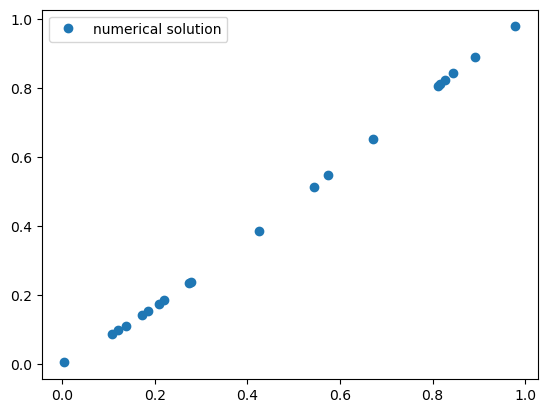

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from vanderpol_num import PINNSolver, FDMSolver

np.random.seed(100)
MU = 1
LEFT_BC, RIGHT_BC = 0, 1
N_SAMPLES = 20 # collect n_samples points in the domain
N_BOUNDARY = 20 # collect n_boundary points on the boundary

X = np.random.uniform(LEFT_BC, RIGHT_BC, (N_SAMPLES, 1))
X_bc = np.array([[LEFT_BC],[RIGHT_BC]])
assert X_bc.shape == (2, 1)
X_combine = np.concatenate([X, X_bc], axis=0)
assert X_combine.shape == (N_SAMPLES+2, 1)
y_bc = np.array([[0],[1]])
y = np.zeros_like(X_combine)
X_input = [X, X_bc]
y_input = [y, y_bc] # bc points are computed twice in y and y_bc


num_model = PINNSolver()
numerical_sol = num_model(torch.tensor(X, dtype=torch.float32)).cpu().detach().numpy()
plt.plot(X, numerical_sol, 'o', label='numerical solution')
plt.legend()
plt.show()

### Reinforcement Learning

We use single RL method to solve the ODE with a non-linear term that causes it doesn't have a closed form solution. Here we define the equation in the `pde.py` file. and use the configuration file `config_haros` to define the hyperparameters of the model.

In [2]:
from ssde import PDESymbolicSolver
from ssde.utils import jupyter_logging
import time
torch.multiprocessing.set_sharing_strategy('file_system')
torch.set_num_threads(1)  
torch.set_num_interop_threads(1) 

@jupyter_logging('./log/vanderpol_gp.log')
def cfs(X_input, y_input):
    model = PDESymbolicSolver("./config/config_vanderpol_gp.json")
    start_time = time.time()
    model.fit(X_input, y_input)
    print('Using time(s):', time.time()-start_time)
    print('Identified parametirc expression:')
    print(model.program_.sympy_expr)
    print('Identified traversal:')
    print(model.program_.traversal)
    return model

model = cfs(X_input, y_input)
model.save('./model/vanderpol_gp.ckpt')

Saved Trainer state to ./model/vanderpol_gp.ckpt/trainer.json.


### Evaluation

We use `SymPy` to get the symbol residual of the identified closed-form solution.  Then evaluate the closed-form solution on the grid points sampled from the computational domain with numerical solution got from the `FD` method.

In [53]:
def pr_eval_data(n_vars):
    np.random.seed(100)
    LEFT_BC, RIGHT_BC = 0, 1
    N_SAMPLES = 1000
    X = np.random.uniform(LEFT_BC, RIGHT_BC, (N_SAMPLES, n_vars))
    X_bc = np.array([[LEFT_BC],[RIGHT_BC]])
    assert X_bc.shape == (2, n_vars)
    X_combine = np.concatenate([X, X_bc], axis=0)
    assert X_combine.shape == (N_SAMPLES+2, n_vars)
    y = source_func(*X_combine.T)
    y_bc = solution_func(*X_bc.T)
    pr_eval = {'domain':(X_combine, y), 'boundary':(X_bc, y_bc)}
    return pr_eval


def Evaluation(pred_solution, eval_set):
    """
    Evaluate the vanderpol equation

    Parameters
    -----------
    pred_solution: sympy_expr
    eval_set: list [X, y]. y is numerical solution of the PDE
    """
    pred_params = dict()
    for symbol in sp.preorder_traversal(pred_solution):
        if isinstance(symbol, sp.Symbol):
            exec('%s = sp.Symbol("%s")' % (symbol.name, symbol.name))
            if symbol.name not in pred_params:
                pred_params[symbol.name] = None
    pred_params = sorted(list(pred_params.keys()))
    print(f'pred_params:{pred_params}')
    pred_source = sp.diff(pred_solution, pred_params[0], 2) \
            + pred_solution - (1- pred_solution**2) * sp.diff(pred_solution, pred_params[0])
    print(f'source:{pred_source}')
    pred_solution_func = sp.lambdify(pred_params, pred_solution, modules='numpy')
    if pred_source == 0:
        source_func = lambda *args: np.zeros_like(args[0])
    else:
        source_func = sp.lambdify(pred_params, pred_source, modules='numpy')

    pr_eval_set = pr_eval_data(n_vars=len(pred_params))
    pr_mse = 0
    i = 0
    for key in pr_eval_set:
        X, y = pr_eval_set[key]
        assert X.shape[0] == y.shape[0], 'X shape: %s, y shape: %s' % (X.shape, y.shape)
        if key == "domain":
            pr_mse += np.sqrt(np.mean((source_func(*X.T) - y)**2))
        elif key == "boundary":
            pr_mse += np.sqrt(np.mean((pred_solution_func(*X.T) - y)**2))
        i += 1
    pr_mse /= i

    X, y = eval_set
    pred_solution_value = pred_solution_func(*X.T)
    mse = np.mean((pred_solution_value - y)**2)
    return mse, pr_mse, pred_solution_func, source_func


We set the numerical solution got from the `FD` method as the `Ground Truth` whose source residual is `2.18e-13`. And test the cfs found by `DESIRE` on the same grid points. The source residual of the cfs is `1.16e-05`. Compared with the `Ground Truth`, the mse of solution found by `DESIRE` method is `2.59e-5`, while the mse of the PINN method is `2.87e-05`.

In [66]:
import numpy as np
from vanderpol_num import PINNSolver, FDMSolver
import torch
from dso.pde import function_map

# numerical solution using FDM
solver = FDMSolver(n_points=1001, mu=1)
y_fdm, r = solver.solve(max_iter=1000)
y_fdm = y_fdm[1:].reshape(-1, 1)
print('PRMSE of FDM:', r)

# numerical solution using PINN
num_model = PINNSolver()
test_X = np.linspace(0, 1, 1000).reshape(-1,1)
X_tensor = torch.tensor(test_X, dtype=torch.float32).requires_grad_(True)
y_hat = num_model(X_tensor)
source_pinn = function_map["van_der_pol"](y_hat, X_tensor).cpu().detach().numpy()
y_pinn = y_hat.cpu().detach().numpy()

assert y_pinn.shape == y_fdm.shape
print('MSE of PINN:', np.mean((y_pinn - y_fdm)**2))
print('PRMSE of PINN:', np.sqrt(np.mean((source_pinn)**2)))

Newton iterations:   1%|          | 11/1000 [00:00<00:36, 26.98it/s]


Converged after 12 iterations
PRMSE of FDM: 2.233293133634509e-13
MSE of PINN: 2.8612951085676277e-07
PRMSE of PINN: 6.885101e-05


In [64]:
# DESIRE
assert y_fdm.shape[0] == test_X.shape[0]
eval_set = [test_X, y_fdm.reshape(-1)]

cfs = sp.sympify("x1*cos(-0.59653854*x1 + exp(0.92597805388875*x1 - 0.86830115*exp(x1)) + 0.29849738)")
# cfs =  sp.sympify("(0.70954114*x1 + 0.70954114*sin(x1))/(2.2949312 - cos(x1 - 1.1396402))")
# cfs =  sp.sympify("1.3606092 - 1.94683270850603 * exp(-0.358412421127265 * exp(1.5484098*x1))")

mse, prmse, pred_solution_func, source_func = Evaluation(cfs, eval_set)
print('PRMSE of cfs:', prmse)
print('MSE of cfs:', mse)

pred_params:['x1']
source:-x1*(((0.86830115*exp(x1) - 0.92597805388875)*exp(0.92597805388875*x1 - 0.86830115*exp(x1)) + 0.59653854)**2*cos(-0.59653854*x1 + exp(0.92597805388875*x1 - 0.86830115*exp(x1)) + 0.29849738) + (0.857435356283597*(0.937712450477061*exp(x1) - 1)**2 - 0.86830115*exp(x1))*exp(0.92597805388875*x1 - 0.86830115*exp(x1))*sin(-0.59653854*x1 + exp(0.92597805388875*x1 - 0.86830115*exp(x1)) + 0.29849738)) + x1*cos(-0.59653854*x1 + exp(0.92597805388875*x1 - 0.86830115*exp(x1)) + 0.29849738) - (-x1**2*cos(-0.59653854*x1 + exp(0.92597805388875*x1 - 0.86830115*exp(x1)) + 0.29849738)**2 + 1)*(-x1*((0.92597805388875 - 0.86830115*exp(x1))*exp(0.92597805388875*x1 - 0.86830115*exp(x1)) - 0.59653854)*sin(-0.59653854*x1 + exp(0.92597805388875*x1 - 0.86830115*exp(x1)) + 0.29849738) + cos(-0.59653854*x1 + exp(0.92597805388875*x1 - 0.86830115*exp(x1)) + 0.29849738)) + 2*((0.86830115*exp(x1) - 0.92597805388875)*exp(0.92597805388875*x1 - 0.86830115*exp(x1)) + 0.59653854)*sin(-0.59653854*x